In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from imagenet_utils import preprocess_input
from input_preparation_new import*

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_width, img_height = 200, 200
train_data_dir = "images/train"
validation_data_dir = "images/dev"
nb_train_samples = 32488
nb_validation_samples = 5723
batch_size = 32
epochs = 1000

In [ ]:
model = load_model('models/ResNet50_trained_f3d.h5')
flatten_model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
flatten_model.summary()

In [ ]:
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

img_generator = img_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        label_name='label_img_train.h5')

bottleneck_img_train = flatten_model.predict_generator(img_generator)
print(bottleneck_img_train.shape)
np.save('bottleneck_img_train.npy', bottleneck_img_train)

img_generator = img_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        label_name='label_img_val.h5')

bottleneck_img_val = flatten_model.predict_generator(img_generator)
print(bottleneck_img_val.shape)
np.save('bottleneck_img_val.npy', bottleneck_img_val)

In [ ]:
model = load_model('models/feature_network.h5')
flatten_model = Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
flatten_model.summary()

In [ ]:
feature_datagen = ImageDataGenerator()

feature_generator = feature_datagen.flow_from_directory(
        train_data_dir,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        out_type='feature',
        label_name='label_feature_train.h5')

bottleneck_feature_train = flatten_model.predict_generator(feature_generator, verbose=1, workers=12, use_multiprocessing=True)
print(bottleneck_feature_train.shape)
np.save('bottleneck_feature_train.npy', bottleneck_feature_train)

In [ ]:
feature_generator = feature_datagen.flow_from_directory(
        validation_data_dir,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        out_type='feature',
        label_name='label_feature_val.h5')

bottleneck_feature_val = flatten_model.predict_generator(feature_generator, verbose=1, workers=12, use_multiprocessing=True)
print(bottleneck_feature_val.shape)
np.save('bottleneck_feature_val.npy', bottleneck_feature_val)

In [3]:
import h5py

def load_label(name):
    label_dataset = h5py.File(name, "r")
    label = np.array(label_dataset["label"][:])
    num_c = np.max(label) + 1
    Y = np.eye(num_c)[label.reshape(-1)]
    return Y

In [4]:
train_img = np.load('bottleneck_img_train.npy')
train_feature = np.load('bottleneck_feature_train.npy')

train_data = np.concatenate((train_img, train_feature), axis=1)
train_labels = load_label('label_img_train.h5')
print(train_data.shape)
print(train_labels.shape)

val_img = np.load('bottleneck_img_val.npy')
val_feature = np.load('bottleneck_feature_val.npy')

val_data = np.concatenate((val_img, val_feature), axis=1)
val_labels = load_label('label_img_val.h5')
print(val_data.shape)
print(val_labels.shape)

(32488, 3072)
(32488, 18)
(5723, 3072)
(5723, 18)


In [5]:
model_top = Sequential()
model_top.add(Dense(18, activation='softmax', input_shape=train_data.shape[1:], name='shopee_output'))

model_top.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=["accuracy"])

In [7]:
# save the model according to the conditions
checkpoint = ModelCheckpoint("models/bottleneck.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=100, verbose=1, mode='auto')

In [8]:
H = model_top.fit(train_data, train_labels,
          epochs=epochs, batch_size=batch_size, 
          callbacks = [checkpoint, early],
          validation_data=(val_data, val_labels))

Train on 32488 samples, validate on 5723 samples
Epoch 1/1000
32488/32488 [==============================] - 3s 78us/step - loss: 1.1835 - acc: 0.6694 - val_loss: 0.7533 - val_acc: 0.7744

Epoch 00001: val_acc improved from -inf to 0.77442, saving model to models/bottleneck.h5
Epoch 2/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.5875 - acc: 0.8248 - val_loss: 0.6246 - val_acc: 0.7992

Epoch 00002: val_acc improved from 0.77442 to 0.79923, saving model to models/bottleneck.h5
Epoch 3/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.4926 - acc: 0.8442 - val_loss: 0.5798 - val_acc: 0.8090

Epoch 00003: val_acc improved from 0.79923 to 0.80902, saving model to models/bottleneck.h5
Epoch 4/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.4478 - acc: 0.8541 - val_loss: 0.5573 - val_acc: 0.8127

Epoch 00004: val_acc improved from 0.80902 to 0.81269, saving model to models/bottleneck.h5
Epoch 5/1000
32488/32488 [

32488/32488 [==============================] - 2s 72us/step - loss: 0.2631 - acc: 0.9083 - val_loss: 0.5171 - val_acc: 0.8268

Epoch 00042: val_acc did not improve
Epoch 43/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2619 - acc: 0.9090 - val_loss: 0.5167 - val_acc: 0.8275

Epoch 00043: val_acc did not improve
Epoch 44/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2604 - acc: 0.9091 - val_loss: 0.5167 - val_acc: 0.8282

Epoch 00044: val_acc did not improve
Epoch 45/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2590 - acc: 0.9097 - val_loss: 0.5185 - val_acc: 0.8265

Epoch 00045: val_acc did not improve
Epoch 46/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2577 - acc: 0.9101 - val_loss: 0.5174 - val_acc: 0.8275

Epoch 00046: val_acc did not improve
Epoch 47/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2564 - acc: 0.9106 - val_loss: 0.5175 - 

32488/32488 [==============================] - 2s 71us/step - loss: 0.2189 - acc: 0.9259 - val_loss: 0.5280 - val_acc: 0.8291

Epoch 00088: val_acc did not improve
Epoch 89/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2183 - acc: 0.9256 - val_loss: 0.5289 - val_acc: 0.8282

Epoch 00089: val_acc did not improve
Epoch 90/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2175 - acc: 0.9258 - val_loss: 0.5289 - val_acc: 0.8288

Epoch 00090: val_acc did not improve
Epoch 91/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2168 - acc: 0.9263 - val_loss: 0.5288 - val_acc: 0.8288

Epoch 00091: val_acc did not improve
Epoch 92/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2163 - acc: 0.9268 - val_loss: 0.5298 - val_acc: 0.8291

Epoch 00092: val_acc did not improve
Epoch 93/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.2155 - acc: 0.9264 - val_loss: 0.5289 - 

32488/32488 [==============================] - 2s 71us/step - loss: 0.1929 - acc: 0.9366 - val_loss: 0.5394 - val_acc: 0.8267

Epoch 00134: val_acc did not improve
Epoch 135/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.1925 - acc: 0.9361 - val_loss: 0.5392 - val_acc: 0.8279

Epoch 00135: val_acc did not improve
Epoch 136/1000
32488/32488 [==============================] - 2s 72us/step - loss: 0.1921 - acc: 0.9362 - val_loss: 0.5387 - val_acc: 0.8282

Epoch 00136: val_acc did not improve
Epoch 137/1000
32488/32488 [==============================] - 2s 73us/step - loss: 0.1916 - acc: 0.9367 - val_loss: 0.5413 - val_acc: 0.8277

Epoch 00137: val_acc did not improve
Epoch 138/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.1912 - acc: 0.9365 - val_loss: 0.5401 - val_acc: 0.8260

Epoch 00138: val_acc did not improve
Epoch 139/1000
32488/32488 [==============================] - 2s 71us/step - loss: 0.1907 - acc: 0.9376 - val_loss: 0.53

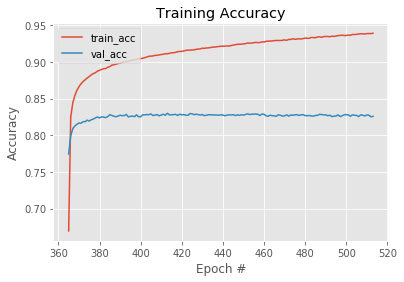

In [9]:
plt.style.use("ggplot")
plt.figure()
N = 149
plt.plot(np.arange(365, N+365), H.history["acc"], label="train_acc")
plt.plot(np.arange(365, N+365), H.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.savefig('bottleneck.png')
plt.show()